In [1]:
import os
import numpy as np 
import cv2
import matplotlib.pyplot as plt 

In [2]:
#Скопируйте имя изображения вверху между '' для его открытия
blue = cv2.imread('MicaSense/IMG_0001_1.tif', -1)
green = cv2.imread('MicaSense/IMG_0001_2.tif', -1)
red = cv2.imread('MicaSense/IMG_0001_3.tif', -1)
nir = cv2.imread('MicaSense/IMG_0001_4.tif', -1) 
rededge = cv2.imread('MicaSense/IMG_0001_5.tif', -1) 

Отобразим синтез каналов

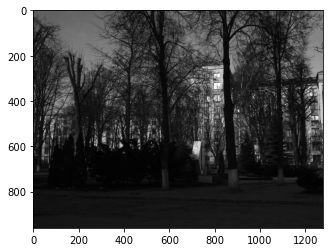

In [3]:
plt.imshow(blue, cmap='gray')
plt.show()

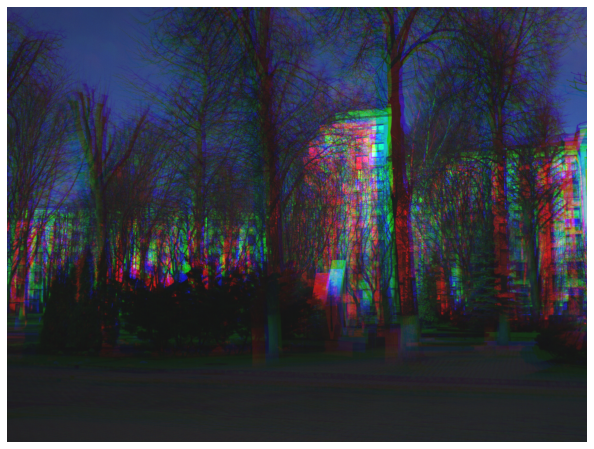

In [4]:
rgb_stack = np.stack((red//2**8, green//2**8,  blue//2**8), axis = 2)
plt.figure(figsize=(15, 8))
plt.imshow(rgb_stack)
plt.axis('off')
plt.show()

Очеивдно, каналы расходятся
Чтобы свести их вместе, будем использовать функцию [findTransformECC](https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html), которая используется, если между снимками есть какой-то сдвиг. Смотрите  [пример](https://www.learnopencv.com/image-alignment-ecc-in-opencv-c-python/)

In [5]:
#Для сопоставления снимков будем использовать рассчитанный по ним градиент яркости

def get_gradient(im) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=11)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=11)
 
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

In [6]:
def shift_image(base_image, warp_image, n_iter = 1000000, inc = 1e-20):
    sz = base_image.shape
    
    # Define the motion model
    warp_mode = cv2.MOTION_TRANSLATION
    
    # Define matrice and initialize the matrix to identity
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    
    #Specify the number of iterations
    number_of_iterations = n_iter
    
    # Specify the threshold of the increment in the correlation coefficient between two iterations
    termination_eps = inc
    
    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    
    # Run the ECC algorithm. The results are stored in warp_matrix
    (cc, warp_matrix) = cv2.findTransformECC(get_gradient(base_image), get_gradient(warp_image), warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
    print("final correlation {:.2f}".format(cc))
    # Use warpAffine for Translation, Euclidean and Affine
    image_shifted = cv2.warpAffine(warp_image, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return(image_shifted)

Для сопоставление каналов сначала будем использовать синий канал в качетсве базового, потом - каждый выходной канал к следующему. Функция печатает корреляцию между базовыс и сопомтавленным изображениям. Эта метрика позволяет понять, насколько приемлем ли результат.

In [7]:
green_shift = shift_image(blue, green)

final correlation 0.74


In [8]:
red_shift = shift_image(green_shift, red)

final correlation 0.77


In [9]:
rededge_shift = shift_image(red_shift, rededge)

final correlation 0.87


In [10]:
nir_shift = shift_image(rededge_shift, nir)

final correlation 0.91


Цветной синтез результата сопоставления каналов

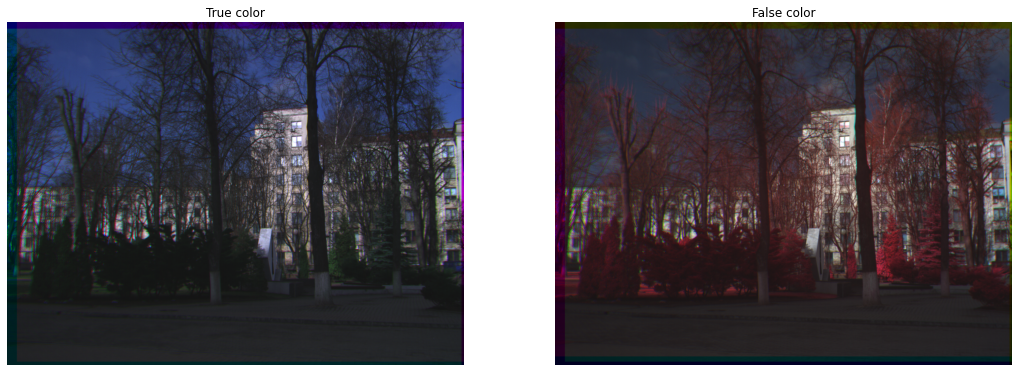

In [11]:
plt.figure(figsize = (18, 10))
plt.subplot(1,2,1)
plt.title('True color')
rgb_stack_transform = np.stack((red_shift//2**8, green_shift//2**8,  blue//2**8), axis = 2)
plt.imshow(rgb_stack_transform)
plt.axis('off')

plt.subplot(1,2,2)
plt.title('False color')
nir_stack_transform = np.stack((nir_shift//2**8, red_shift//2**8, green_shift//2**8), axis = 2)
plt.imshow(nir_stack_transform)
plt.axis('off')

plt.show()

Уже лучше, но изображение выглядит тёмным. В одной из лабораторных работ мы выполняли эквализацию гистограммы. Используем эту функцию здесь

In [12]:
# Эквализация работает только на одноканальных 8-битных данных
R = cv2.equalizeHist((red_shift//2**8).astype('uint8'))
G = cv2.equalizeHist((green_shift//2**8).astype('uint8'))
B = cv2.equalizeHist((blue//2**8).astype('uint8'))

In [13]:
nir_stack_transform_8bit_eq = np.stack((R, G, B), axis = 2)

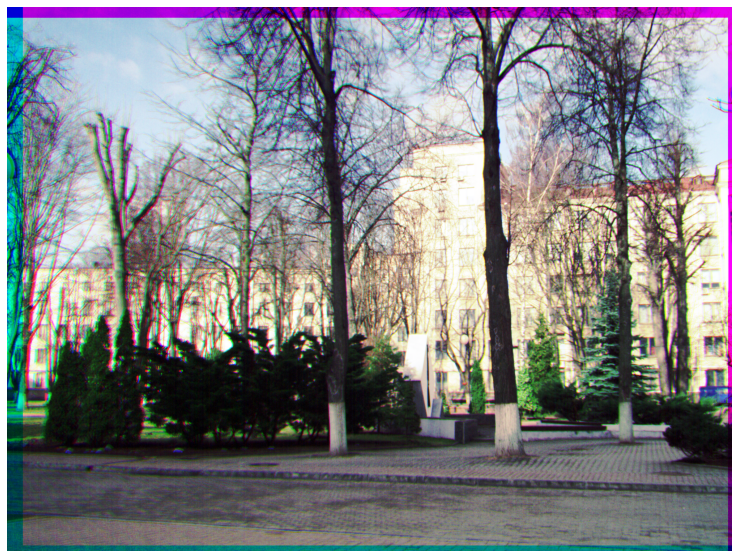

In [14]:
plt.figure(figsize = (18, 10))
plt.imshow(nir_stack_transform_8bit_eq)
plt.axis('off');

Гораздо лучше. Сохраним и скачаем результат. не забываем поменять каналы местами

In [15]:
cv2.imwrite('MicaSense/Aligned.jpg', np.stack((B, G, R), axis = 2)) 

True